In [28]:
import copy
import japanize_matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy 
from matplotlib.pyplot import imshow
from numpy.random import randn
from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston

In [3]:
def liner(X, y):
    """linear regression

    Args:
        X (_type_): 説明変数
        y (_type_): target 
    """
    p = X.shape[1]
    x_bar = [np.mean(X[:, j]) for j in range(p)]
    X = [X[:, j]-x_bar[j] for j in range(p)]
    
    y_bar = np.mean(y)
    y = y - y_bar
    
    beta = np.dot(np.linealg.inv(np.dot(X.T, X)), np.dot(X.T, y))
    
    beta_0 = y_bar - np.dot(x_bar, beta)
    
    return beta, beta_0

In [17]:
def soft_th(lam, x):
    return np.sign(x)*np.maximum(np.abs(x)-lam, np.zeros(1))

def centralize(X0, y0, standardize=True):
    X = copy.copy(X0)
    y = copy.copy(y0)
    n, p = X.shape
    X_bar = np.zeros(p)                   # Xの各列の平均
    X_sd = np.zeros(p)                    # Xの各列の標準偏差
    for j in range(p):
        X_bar[j] = np.mean(X[:, j])
        X[:, j] = X[:, j] - X_bar[j]      # Xの各列の中心化
        X_sd[j] = np.std(X[:, j])
        if standardize is True:
            X[:, j] = X[:, j] / X_sd[j]   # Xの各列の標準化
    if np.ndim(y) == 2:
        K = y.shape[1]
        y_bar = np.zeros(K)               # yの平均
        for k in range(K):
            y_bar[k] = np.mean(y[:, k])
            y[:, k] = y[:, k] - y_bar[k]  # yの中心化
    else:                                 # yがベクトルの場合
        y_bar = np.mean(y)
        y = y - y_bar
    return X, y, X_bar, X_sd, y_bar
    
def linear_lasso(X, y, lam=0, beta=None):
    n, p = X.shape
    if beta is None:
        beta = np.zeros(p)
    X, y, X_bar, X_sd, y_bar = centralize(X, y)   # 中心化（下記参照）
    eps = 1
    beta_old = copy.copy(beta)
    while eps > 0.00001:    # このループの収束を待つ
        for j in range(p):
            r = y
            for k in range(p):
                if j != k:
                    r = r - X[:, k] * beta[k]
            z = (np.dot(r, X[:, j]) / n) / (np.dot(X[:, j], X[:, j]) / n)
            beta[j] = soft_th(lam, z)
        eps = np.linalg.norm(beta - beta_old, 2)
        beta_old = copy.copy(beta)
    beta = beta / X_sd   # 各変数の係数を正規化前のものに戻す
    beta_0 = y_bar - np.dot(X_bar, beta)
    return beta, beta_0
                    

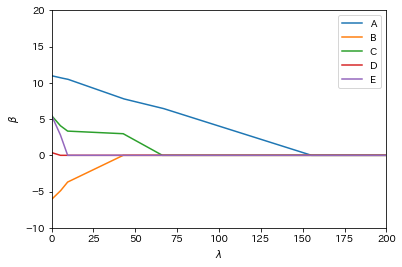

In [18]:
df = np.loadtxt("./data/input/crime.txt", delimiter="\t")
X = df[:, [i for i in range(2, 7)]]
p = X.shape[1]
y = df[:, 0]
lambda_seq = np.arange(0, 200, 0.1)
plt.xlim(0, 200)
plt.ylim(-10, 20)
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\beta$")
labels = ["A", "B", "C", "D", "E"]

r = len(lambda_seq)

coef_seq = np.zeros((r, p))

for i in range(r):
    coef_seq[i, :], _ = linear_lasso(X, y, lambda_seq[i])

for j in range(p):
    plt.plot(lambda_seq, coef_seq[:, j], label=labels[j])
plt.legend(loc="upper right")

In [19]:
def warm_start(X, y, lambda_max=100):
    dec = np.round(lambda_max/50) # lambdaの値をN分割する
    lambda_seq = np.arange(lambda_max, 1, -dec)
    r = len(lambda_seq)
    p = X.shape[1]
    beta = np.zeros(p)
    coef_seq = np.zeros((r, p))
    
    for k in range(r):
        beta, _ = linear_lasso(X, y, lambda_seq[k], beta)
        coef_seq[k, :] = beta
    return coef_seq

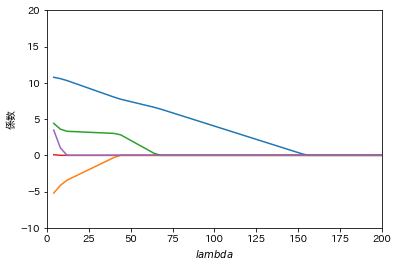

In [24]:
df = np.loadtxt("../sparse_estimation/data/input/crime.txt", delimiter="\t")
X = df[:, [i for i in range(2, 7)]]
p = X.shape[1]
y = df[:, 0]
coef_seq = warm_start(X, y, 200)
lambda_max = 200
dec = round(lambda_max/50)
lambda_seq = np.arange(lambda_max, 1, -dec)
plt.ylim(np.min(coef_seq), np.max(coef_seq))
plt.xlabel(r"$lambda$")
plt.ylabel("係数")
plt.xlim(0, 200)
plt.ylim(-10, 20)
for j in range(p):
    plt.plot(lambda_seq, coef_seq[:, j])

In [25]:
def ridge(X, y, lam=0):
    n, p = X.shape
    X, y, X_bar, X_sd, y_bar = centralize(X,y)
    beta = np.dot(np.linalg.inv(np.dot(X.T, X) + n*lam*np.eye(p)), np.dot(X.T, y))
    
    beta = beta/X_sd
    beta_0 = y_bar - np.dot(X_bar, beta)
    return beta, beta_0

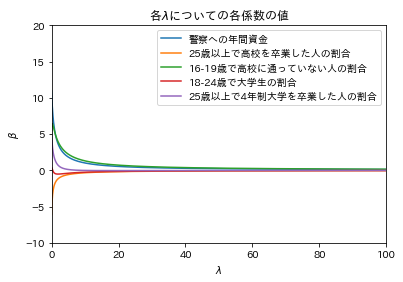

In [27]:
df = np.loadtxt("../sparse_estimation/data/input/crime.txt", delimiter="\t")
X = df[:, [i for i in range(2, 7)]]
p = X.shape[1]
y = df[:, 0]
lambda_seq = np.arange(0, 200, 0.1)
plt.xlim(0, 100)
plt.ylim(-10, 20)
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\beta$")
plt.title(r"各$\lambda$についての各係数の値")
labels = ["警察への年間資金", "25歳以上で高校を卒業した人の割合",
          "16-19歳で高校に通っていない人の割合",
          "18-24歳で大学生の割合", "25歳以上で4年制大学を卒業した人の割合"]
r = len(lambda_seq)
beta = np.zeros(p)
coef_seq = np.zeros((r, p))
for i in range(r):
    beta, beta_0 = ridge(X, y, lambda_seq[i])
    coef_seq[i, :] = beta
for j in range(p):
    plt.plot(lambda_seq, coef_seq[:, j], label=labels[j])
plt.legend(loc="upper right")

In [34]:
def R2(x, y):
    model = LinearRegression()
    model.fit(x, y)           # モデルの訓練
    y_hat = model.predict(x)  # 予測値の表示
    y_bar = np.mean(y)
    RSS = np.dot(y - y_hat, y - y_hat)
    TSS = np.dot(y - y_bar, y - y_bar)
    return 1 - RSS / TSS

def vif(x):
    p = x.shape[1]
    values = np.zeros(p)
    for j in range(p):
        ind = [i for i in range(p) if i != j]
        values[j] = 1 / (1 - R2(x[:, ind], x[:, j]))
    return values


In [35]:
boston = load_boston()
n = boston.data.shape[0]
z = np.concatenate([boston.data, boston.target.reshape([n, 1])], 1)
vif(z)

/home/yuki/Documents/study/statisticalLearning/venv38statisticalLearning/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alt

array([1.83153668, 2.35218589, 3.99250315, 1.09522267, 4.58692024,
       2.26037436, 3.10084282, 4.39600725, 7.80819843, 9.20554209,
       1.99301566, 1.38146295, 3.5815848 , 3.85568427])

In [36]:
def elastic_net(X, y, lam=0, alpha=1, beta=None):                     #
    n, p = X.shape
    if beta is None:
        beta = np.zeros(p)
    X, y, X_bar, X_sd, y_bar = centralize(X, y)   # 中心化
    eps = 1
    beta_old = copy.copy(beta)
    while eps > 0.00001:    # このループの収束を待つ
        for j in range(p):
            r = y
            for k in range(p):
                if j != k:
                    r = r - X[:, k] * beta[k]
            z = (np.dot(r, X[:, j]) / n)                                    ##
            beta[j] = (soft_th(lam * alpha, z)                              ##
                       / (np.dot(X[:, j], X[:, j]) / n + (1-alpha) * lam))  ##
        eps = np.linalg.norm(beta - beta_old, 2)
        beta_old = copy.copy(beta)
    beta = beta / X_sd   # 各変数の係数を正規化前のものに戻す
    beta_0 = y_bar - np.dot(X_bar, beta)
    return beta, beta_0

In [37]:
def cv_linear_lasso(x, y, alpha=1, k=10):
    lam_max = np.max(np.dot(x.T, y) / np.dot(x.T, x))
    lam_seq = np.array(range(100))**3 / 1000000 * lam_max
    n = len(y)
    m = int(n / k)
    r = n % k
    S_min = np.inf
    for lam in lam_seq:
        S = 0
        for i in range(k):
            if i < k - r:
                index = list(range(i*m, i*m + m))
            else:
                index = list(range(i*m + (i-k+r), i*m + (m+i-k+r+1)))
                # nをkで割れない場合
            _index = list(set(range(n)) - set(index))
            beta, beta0 = elastic_net(x[_index, ], y[_index], lam, alpha)
            z = np.linalg.norm((y[index] - beta0 - np.dot(x[index], beta)), 2)
            S = S + z**2
        if S < S_min:
            S_min = S.copy()
            lam_best = lam.copy()
            beta0_best = beta0.copy()
            beta_best = beta.copy()
    return lam_best, beta0_best, beta_best, S_min

Text(0.5, 1.0, '$y=x^2-3x+|x|$')

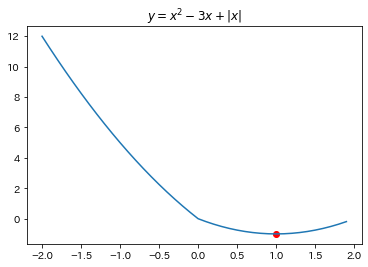

In [39]:
x = np.arange(-2, 2, 0.1)
y = x**2 -3*x +np.abs(x)

plt.plot(x, y)
plt.scatter(1, -1, c="red")
plt.title("$y=x^2-3x+|x|$")

Text(0.5, 1.0, '$y=x^2-3x+|x|$')

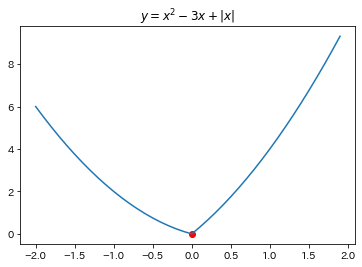

In [41]:
x = np.arange(-2, 2, 0.1)
y = x**2+x +2*np.abs(x)

plt.plot(x, y)
plt.scatter(0, 0, c="red")
plt.title("$y=x^2-3x+|x|$")